In [68]:
import pandas as pd
import os
from tqdm import tqdm
import re
from konlpy.tag import Okt

## 데이터 불러오기
폴더명에서 (연도) 부분을 삭제했습니다

In [126]:
def data_load(king):
    data_list = os.listdir(f'./data/Result/{king}')
    text_list = []
    for data in tqdm(data_list):
        with open(f"./data/Result/{king}/{data}", encoding="UTF-8") as f:
            text=f.read()
    
        text_list = text_list + text.split("=====")
        
    return text_list

In [127]:
king_names = ["8대 예종", "9대 성종", "10대 연산군", "11대 중종", "12대 인종", "21대 영조"]
text_list = []
for king in king_names:
    text=data_load(king)
    text_list.append(text)

100%|███████████████████████████████████████████████████████████████████████████████| 627/627 [00:02<00:00, 277.55it/s]


## 데이터 전처리

In [138]:
def text_clear(text_list):
    f1 = lambda x : re.sub(r'[一-龥-𧭢ㆍ]', "", x)
    f2 = lambda x : re.sub(r'[^\d\w\s]', "", x)
    f3 = lambda x : re.sub("\w\w실록.+\n","",x ,count=1)
    f4 = lambda x : re.sub("\n{1}", " ", x)
    f5 = lambda x : re.sub("\d\d\d", "", x)
    f6 = lambda x : x.strip()

    f_list = [f1,f2,f3,f4,f5,f6]

    for f in f_list:
        text_list = list(map(f, text_list))
    
    text_list=list(filter(None, text_list))
    
    return text_list

<>:4: DeprecationWarning: invalid escape sequence \w
<>:6: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \w
<>:6: DeprecationWarning: invalid escape sequence \d
<ipython-input-138-e30e47367a68>:4: DeprecationWarning: invalid escape sequence \w
  f3 = lambda x : re.sub("\w\w실록.+\n","",x ,count=1)
<ipython-input-138-e30e47367a68>:6: DeprecationWarning: invalid escape sequence \d
  f5 = lambda x : re.sub("\d\d\d", "", x)


In [139]:
clear_text_list = []
for text in tqdm(text_list):
    clear_text=text_clear(text)
    clear_text_list.append(clear_text)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:40<00:00,  6.67s/it]


## "백성"이 포함된 문서만 남기기

In [140]:
people_text_list=[[text for text in text_list if "백성" in text] for text_list in clear_text_list]

In [214]:
for i in people_text_list:
    print(len(i))

115
3245
1124
3682
57
2906


## 품사 태깅 후 명사 형용사만 남기기

In [158]:
#태깅하기
okt = Okt()
total_morphs_list = []
for text_list in tqdm(people_text_list):
    morphs_list=[]
    for text in text_list:
        okt_morphs=okt.pos(text)
        morphs_list.append(okt_morphs)
    total_morphs_list.append(morphs_list)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [37:14<00:00, 372.35s/it]


In [160]:
#명사만 남기기
king_na_list = []
for morphs_list in tqdm(total_morphs_list):
    total_na_list = []
    for morphs in morphs_list:
        na_list = []
        for word, pos in morphs:
            if (pos == "Noun") and (len(word)!=1):
                na_list.append(word)
        total_na_list.append(na_list)
    king_na_list.append(total_na_list)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.51it/s]


In [171]:
king_na_dict=dict(zip(king_names,king_na_list))

## Corpus 생성

In [163]:
from gensim import corpora
from gensim import models
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [203]:
dictionary=corpora.Dictionary(king_na_dict["21대 영조"]) #여기를 바꿔주면 왕 별로 모델링 가능합니다.
corpus = []
for na in total_na_list:
    bow = dictionary.doc2bow(na)
    corpus.append(bow)

## 모델링

In [212]:
#토픽 수와 토픽 키워드 수 지정
NUM_TOPICS = 10    #토픽 수
NUM_TOPIC_WORDS = 15    #토픽 키워드 수

#모델 시행
lda_model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS,
                        id2word=dictionary,
                        alpha='auto')

#실행할 때마다 결과가 달라짐; 원하는 결과가 나올 때까지

## 최적의 topic 수 구하기

In [207]:
#log perplexity 계산
start1 = 2         #최소 토픽 수
limit1 = 40        #최대 토픽 수
step1 = 5          #계산할 간격
perplexity_scores=[]
for num_topics in range(start1, limit1, step1):
    model = models.ldamodel.LdaModel(corpus, num_topics=num_topics,
                    id2word=dictionary,
                    alpha='auto')
    perplexity_scores.append(model.log_perplexity(corpus))

In [208]:
perplexity_scores

[-8.159731841985119,
 -8.32726615154846,
 -8.596300518246398,
 -8.79349628991185,
 -9.031641600266761,
 -9.191861126240514,
 -9.39682135254931,
 -9.530729533040475]

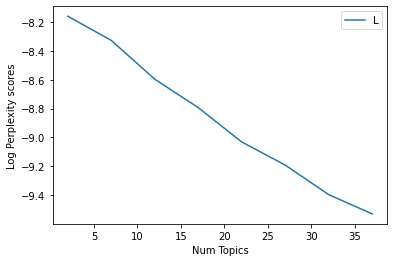

In [209]:
import matplotlib.pyplot as plt
x = range(start1, limit1, step1)
plt.plot(x, perplexity_scores)
plt.xlabel("Num Topics")
plt.ylabel("Log Perplexity scores")
plt.legend(("Log Perplexity"), loc='best')
plt.show()

# 시각화

In [213]:
prepared_data = gensimvis.prepare(lda_model, corpus, dictionary)

#주피터에서 보기
pyLDAvis.display(prepared_data)